In [4]:
# Работа с изображениями и текстом

from PIL import Image, ImageDraw, ImageFont

out = Image.new("RGB", (150, 100), (255, 255, 255))
d = ImageDraw.Draw(out)
d.line([0,0, 80,80], fill=128)
d.multiline_text((10,10), "Hello\nWorld", font=d.getfont(), fill=(0, 200, 0))
out.save('newImage.png', 'png')

In [2]:
import numpy as np
import pandas as pn
import math
from PIL import Image, ImageDraw, ImageFont

import config

ocr = pn.read_csv('ocrData.csv')

# Точка начала базиса.  

one_point = ocr.query("text == 'Указания'")

# Вспомогательные вектора (в принципе достаточно одного, для масштабирования использую А, второй для быстрой замены при тестах).  

a_point = ocr.query("text == 'Прием'")
b_point = ocr.query("text == 'Сдача'")


with Image.open("test.png") as doc_image:

    draw = ImageDraw.Draw(doc_image)
    basis = config.basis
    ofset_x = one_point.iloc[0]['left']
    ofset_y = one_point.iloc[0]['top']

    # Определение коэффициента масштабирования.  
    scale_x = (b_point.left - ofset_x) / basis['B']['x']
    scale_y = (b_point.top - ofset_y) / basis['B']['y']
    scale_y = 15
    scale_x = 5
    # Координаты точки начала   
    basis_position = [ofset_x, ofset_y]
    
    for point in basis:
        vector = basis[point]
        vector = [
            vector['x'] * scale_x + ofset_x,
            vector['y'] * scale_y + ofset_y
        ]
        draw.line(basis_position + vector, fill=128, width=10)


    doc_image.save("test.png", "PNG")

4
4
4
2
168
[255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 255 255   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   

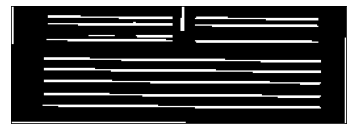

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


IMG_SIZE = 256
LINE_COUNT = 3
def get_structure(img, size=IMG_SIZE) -> np.array:
    _, thresh = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    k_size = int(max(img.shape) // 196)
    h_kernel = np.ones((1, k_size), np.uint8)
    v_kernel = np.ones((k_size, 1), np.uint8)
    h_erosion = cv2.erode(thresh, h_kernel, iterations=5)
    v_erosion = cv2.erode(thresh, v_kernel, iterations=5)
    erosion = cv2.add(h_erosion, v_erosion)
    dil_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
    dilation = cv2.dilate(erosion, dil_kernel, iterations=3)
    resize = cv2.resize(dilation, (size, size),
                        interpolation=cv2.INTER_NEAREST)
    k_size = int(k_size // 2)
    h_kernel = np.ones((1, k_size), np.uint8)
    v_kernel = np.ones((k_size, 1), np.uint8)
    h_erosion = cv2.erode(resize, h_kernel, iterations=1)
    v_erosion = cv2.erode(resize, v_kernel, iterations=1)
    erosion = cv2.add(h_erosion, v_erosion)
    result = erosion
    return result

def get_line_position(structure, crop_y):
    line_y_position = 0
    line_finded_count = 0
    img_array = structure[crop_y:-1, 0:-1]
    
    np.savetxt("imageArray.csv", structure, delimiter=",",fmt="%s")
    cv2.imwrite('string_structure.png', structure)
    plt.imshow(structure, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.imshow(img_array, cmap = 'gray')
    for (indx, line) in enumerate(img_array):
        line = line > 0
        print(line.sum())
        if line.sum() > 3:
            line_finded_count += 1

        if(line_finded_count == 3):
            print(indx)
            line_y_position = indx
            break    

    line_y_position += crop_y        
    print(line_y_position)
    print(structure[line_y_position])
    return line_y_position

def get_data_insert_point(img, basis_point):
    doc_x = len(img[0])
    doc_y = len(img)
    structure = get_structure(img)
    crop_y = int(IMG_SIZE / img.shape[0] * basis_point[0])
    point_y = get_line_position(structure, crop_y)
    return [basis_point[0], point_y]

img = cv2.imread('test.png',0)
point = get_data_insert_point(img, [1300, 970])
print(point)





In [5]:
import numpy as np
import cv2

img = cv2.imread('../test.png',0)
cv2.imshow('image',img)
k = cv2.waitKey(0)
if k == 27:         # wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'): # wait for 's' key to save and exit
    cv2.imwrite('messigray.png',img)
    cv2.destroyAllWindows()

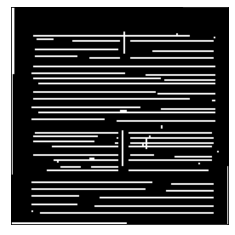

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


IMG_SIZE = 128
LINE_COUNT = 3
def get_structure(img, size=IMG_SIZE) -> np.array:
    _, thresh = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    k_size = int(max(img.shape) // 196)
    h_kernel = np.ones((1, k_size), np.uint8)
    v_kernel = np.ones((k_size, 1), np.uint8)
    h_erosion = cv2.erode(thresh, h_kernel, iterations=5)
    v_erosion = cv2.erode(thresh, v_kernel, iterations=5)
    erosion = cv2.add(h_erosion, v_erosion)
    dil_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
    dilation = cv2.dilate(erosion, dil_kernel, iterations=3)
    resize = cv2.resize(dilation, (size, size80
                        interpolation=cv2.INTER_NEAREST)
    plt.imshow(resize, cmap = 'gray')
    plt.xticks([]), plt.yticks([])                    
    k_size = int(k_size // 2)
    h_kernel = np.ones((1, k_size), np.uint8)
    v_kernel = np.ones((k_size, 1), np.uint8)
    h_erosion = cv2.erode(resize, h_kernel, iterations=1)
    v_erosion = cv2.erode(resize, v_kernel, iterations=1)
    erosion = cv2.add(h_erosion, v_erosion)
    result = erosion


img = cv2.imread('test.png',0)
get_structure(img)

In [1]:
# Загрузка окра, запускать при смене документа.  

import urllib3

import config

http = urllib3.PoolManager()
r = http.request('GET', config.ocr_href)
ocrData = r.data.decode('utf-8')
f = open('ocrData.csv', 'w')
f.write(ocrData)
f.close()

In [2]:
# Обновление файла с картинкой документа (очистка всего что нарисовалось локально).  

import urllib3

import config

http = urllib3.PoolManager()
r = http.request('GET', config.image_href)
f = open(config.image_name, 'wb')
print(config.image_href)
print(config.type)
f.write(r.data)
f.close()


http://api.sherlocktest.kt-team.de/api/pages/5fa930039619c4b351162737/image/actual
ТТН


(968, 1171)
1137
(968, 1137)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 255 255 255 255 255 255   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  

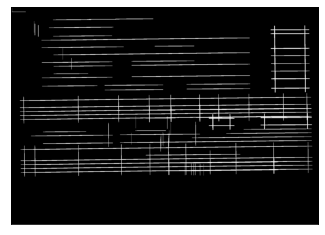

In [4]:
# Эрозия для правильных строк при небольшом повороте и прямых документов

import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pn
from PIL import Image, ImageDraw, ImageFont


import config


IMG_SIZE = 512

Point = (int, int)

result = cv2.imread('test.png', 0)

ret, result = cv2.threshold(result,0,255,cv2.THRESH_BINARY_INV)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,25))
vertical = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)

kernel = np.ones((50,1),np.uint8)
vertical = cv2.dilate(vertical,kernel,iterations = 1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(110,1))
horisontal = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)

kernel = np.ones((2,50),np.uint8)
horisontal = cv2.dilate(horisontal,kernel,iterations = 1)

result = cv2.add(horisontal,vertical)
# result = vertical
plt.imshow(result, cmap = 'gray')
plt.xticks([]), plt.yticks([])
cv2.imwrite('resFirstKernel.png', result)
np.savetxt("structure.csv", result, delimiter=",",fmt="%s")

structure = result


def find_left_column(orinentir, structure) -> Point:
    row = structure[orinentir[0], :orinentir[1]]
    left = 0
    lenght = len(row)
    while lenght:
        lenght -= 1
        point = row[lenght]
        if point > 0:
            left = lenght
            break
            
    print(left)
    return (orinentir[0], left)

type = config.type
if type == 'ТТН':
    row_count = 4
    orinentir_name = 'прибытия'
else:
    row_count = 3
    orinentir_name = 'Сдача'

ocr = pn.read_csv('ocrData.csv')
orinentir_ocr = ocr.query(f"text == '{orinentir_name}'")
left = orinentir_ocr.iloc[0]['left']
top = orinentir_ocr.iloc[0]['top']
orinentir = (top, left)

print(orinentir)
column_point = find_left_column(orinentir, structure)
print(column_point)

def find_n_row(column_point, structure, n) -> Point:
    offset = 20
    column = structure[column_point[0]:-1,column_point[1]+2:-1][:,offset]
    
    print(column)
    row_position = 0
    line_finded_count = 0
    index = 0
    while True:
        point = column[index]
        print(index,point)
        if point == 255 and index-1 > 0 and column[index-1] == 0:
            line_finded_count += 1

        if line_finded_count == n:
            print(index)
            row_position = index
            break
        
        index +=1

        if index == len(column):
            break

    return (column_point[1],row_position + column_point[0])


row_point = find_n_row(column_point, structure, row_count)
print(row_point)

with Image.open("test.png") as doc_image:
    draw = ImageDraw.Draw(doc_image)

    draw.line((0,0) + row_point, fill=128, width=10)
    doc_image.save("test.png", "PNG")

